# Training Log Visualization

This notebook parses `training_log.md` and currently visualizes the change in invalid rates for `extend_decision` tasks.

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict

# Configure plotting
%matplotlib inline
import matplotlib.font_manager as fm
try:
    fm.fontManager.addfont('/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')
except:
    pass
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'SimHei', 'DejaVu Sans', 'Arial'] # Try to support Chinese if available
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def parse_log(file_path):
    data = []
    
    # Regex patterns
    # Example: [reward_diag] steps 0..10 invalid_rate=0.456 (73/160)
    step_pattern = re.compile(r'\[reward_diag\] steps (\d+)\.\.(\d+).*')
    
    # Example: [reward_diag]  - extend_decision: invalid_rate=0.830 (73/88) top=extend_decision_extend_sec_exceeds_max_soft:52, ...
    task_pattern = re.compile(r'\[reward_diag\]\s+-\s+(\w+):\s+invalid_rate=([\d\.]+)\s+\((\d+)/(\d+)\)\s+top=(.*)')
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return pd.DataFrame()
        
    current_step_end = None
    
    for line in lines:
        line = line.strip()
        step_match = step_pattern.search(line)
        if step_match:
            current_step_end = int(step_match.group(2))
            continue
            
        task_match = task_pattern.search(line)
        if task_match and current_step_end is not None:
            task_name = task_match.group(1)
            
            # We focus on extend_decision
            if task_name != 'extend_decision':
                continue
                
            invalid_rate = float(task_match.group(2))
            invalid_count = int(task_match.group(3))
            total_count = int(task_match.group(4))
            top_reasons_str = task_match.group(5)
            
            # Parse reasons
            reasons = {}
            if top_reasons_str != "n/a":
                parts = top_reasons_str.split(', ')
                for part in parts:
                    if ':' in part:
                        try:
                            # Split from right to handle colons in names if any (though unlikely)
                            r_name, r_count = part.rsplit(':', 1)
                            reasons[r_name] = int(r_count)
                        except ValueError:
                            continue
            
            entry = {
                'step': current_step_end,
                'task': task_name,
                'invalid_rate': invalid_rate,
                'total_count': total_count,
                **reasons 
            }
            data.append(entry)
            
    return pd.DataFrame(data).fillna(0)

df = parse_log('training_log.md')
print("Data loaded:", len(df), "records")
df.head()

Data loaded: 839 records


,step,task,invalid_rate,total_count,extend_decision_extend_sec_exceeds_max_soft,extend_decision_extend_sec_nonzero_when_no_soft,extend_decision_final_green_out_of_bounds,extend_decision_extend_when_at_max_green,extend_decision_parse_failed
0,10,extend_decision,0.830,88,52.0,21.0,0.0,0.0,0.0
1,20,extend_decision,0.830,112,58.0,34.0,1.0,0.0,0.0
2,30,extend_decision,0.870,108,73.0,21.0,0.0,0.0,0.0
3,40,extend_decision,0.830,88,53.0,20.0,0.0,0.0,0.0
4,50,extend_decision,0.807,88,49.0,21.0,1.0,0.0,0.0


Plotting English Version...


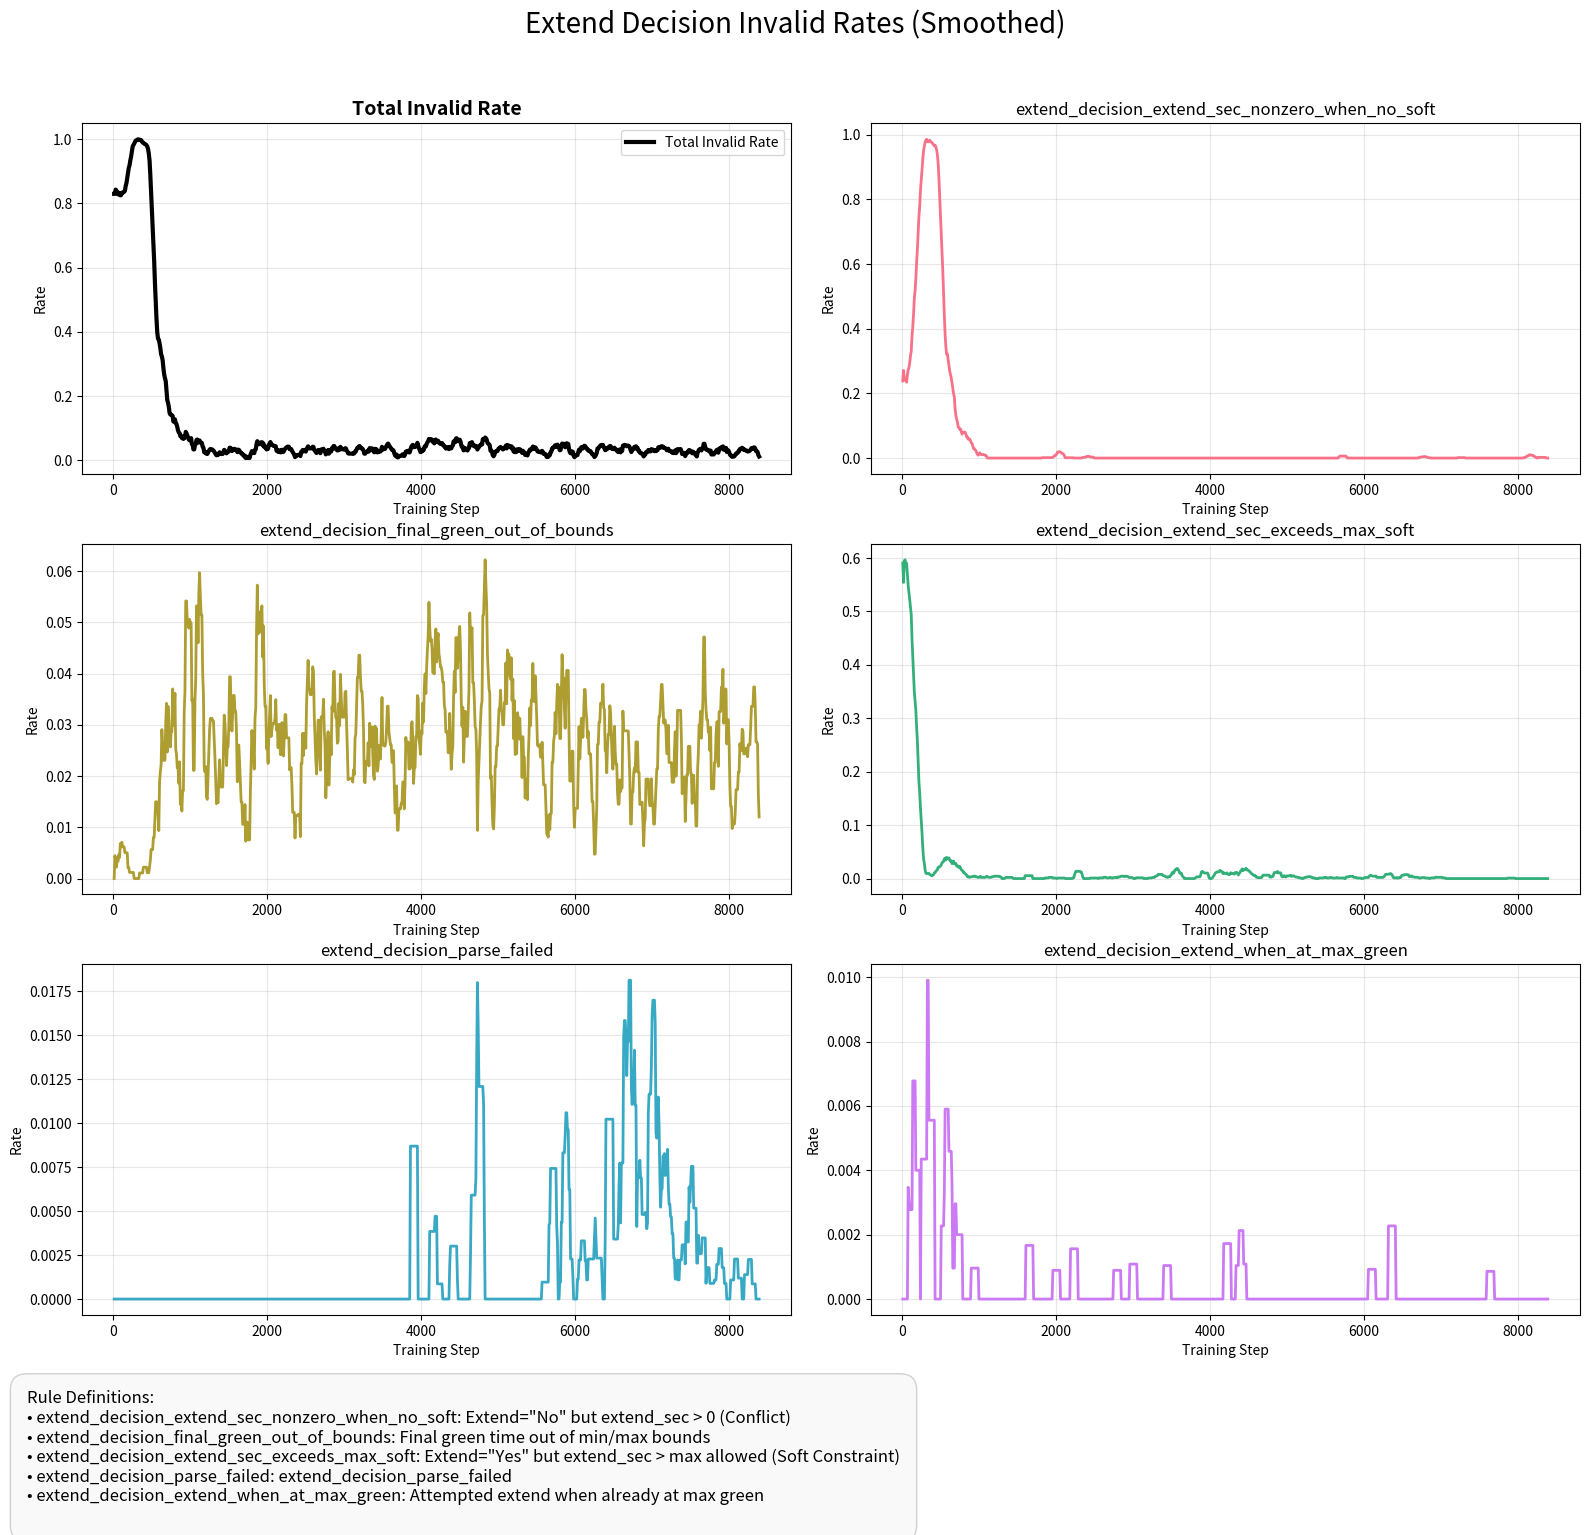

Plotting Chinese Version...


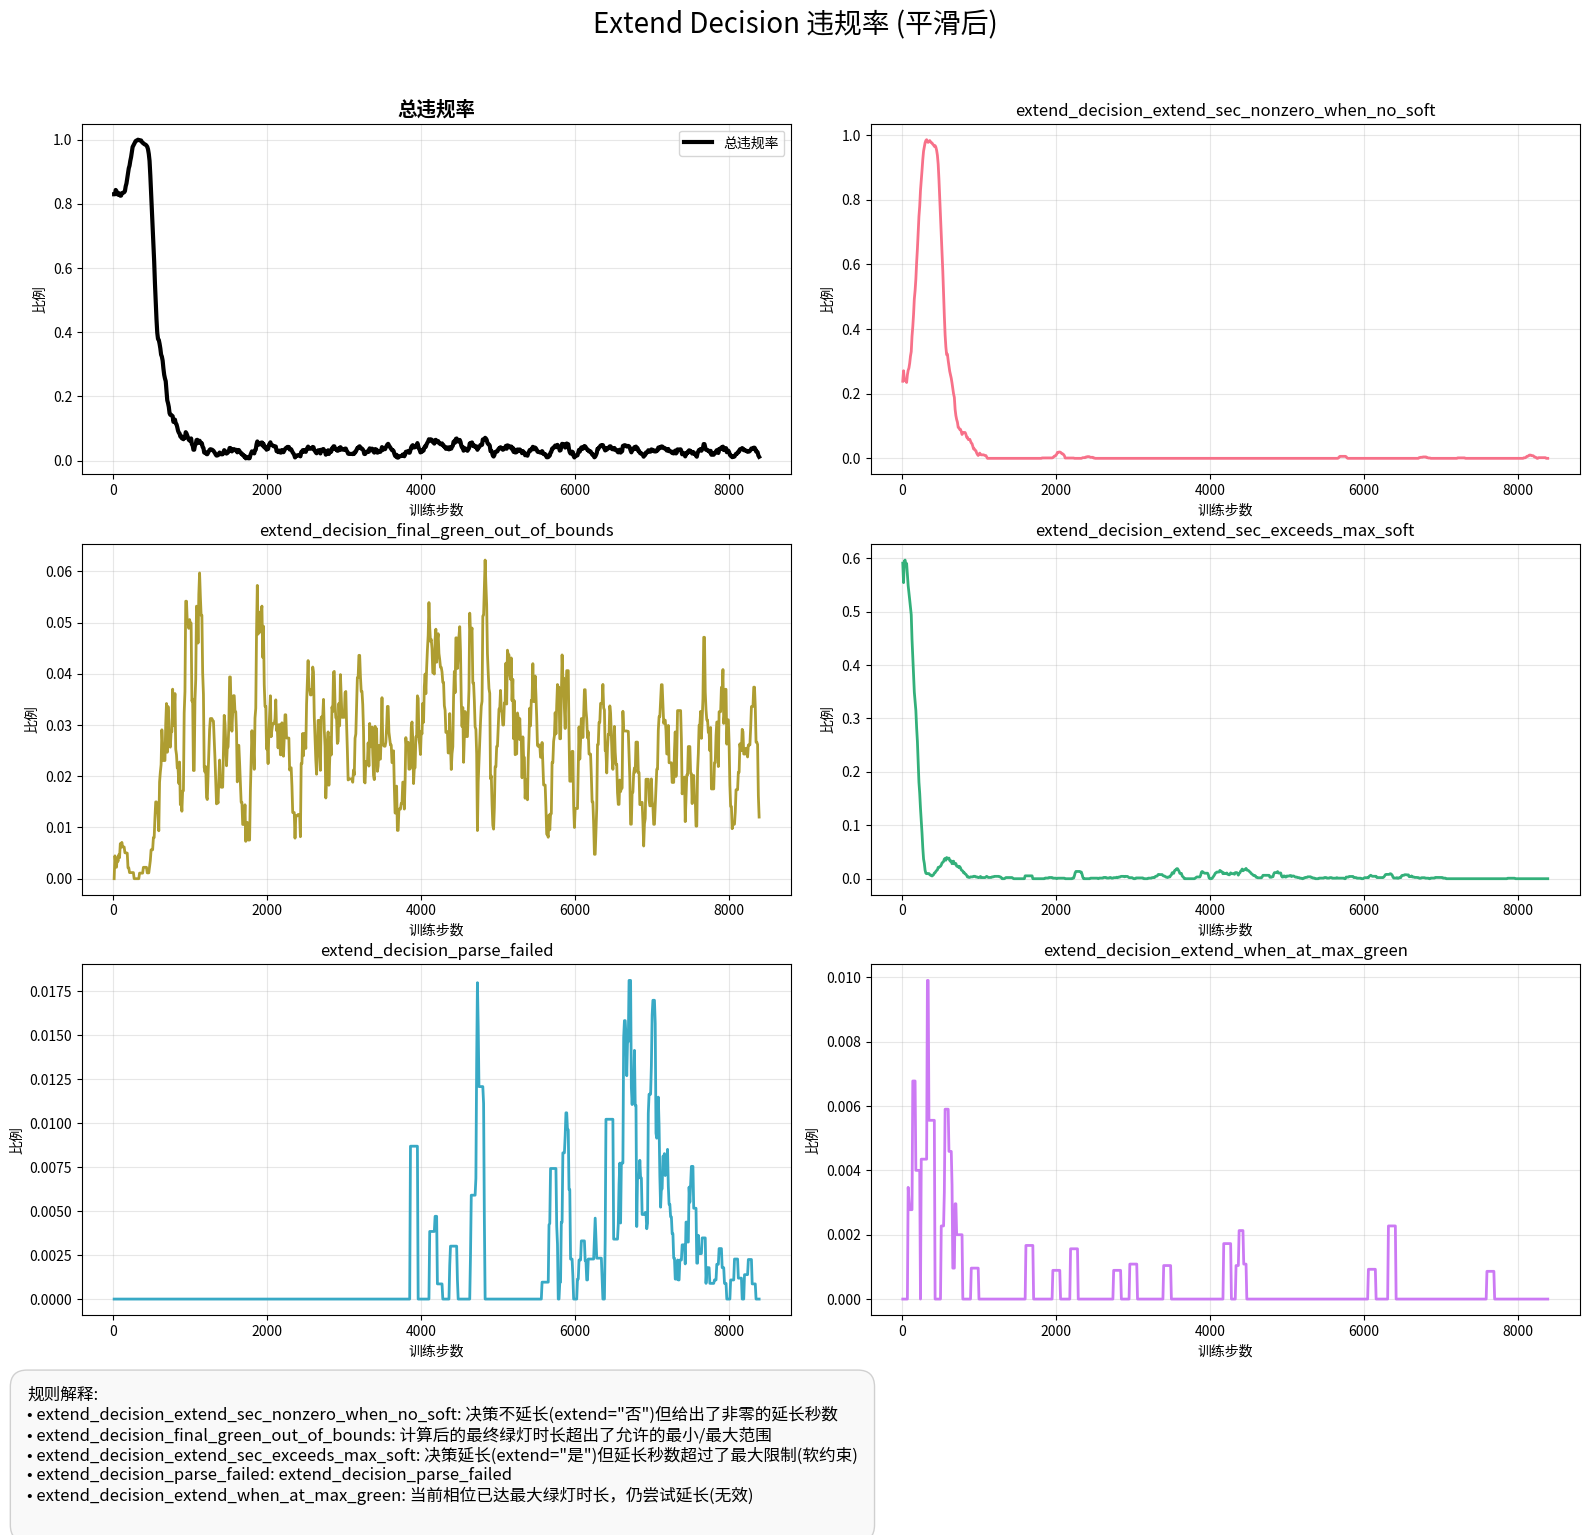

In [3]:
# Definitions for Chinese and English
definitions_en = {
    'extend_decision_extend_sec_nonzero_when_no_soft': 'Extend="No" but extend_sec > 0 (Conflict)',
    'extend_decision_extend_sec_exceeds_max_soft': 'Extend="Yes" but extend_sec > max allowed (Soft Constraint)',
    'extend_decision_final_green_out_of_bounds': 'Final green time out of min/max bounds',
    'extend_decision_extend_when_at_max_green': 'Attempted extend when already at max green',
    'extend_decision_limit_missing': 'Missing phase limits',
}

definitions_cn = {
    'extend_decision_extend_sec_nonzero_when_no_soft': '决策不延长(extend="否")但给出了非零的延长秒数',
    'extend_decision_extend_sec_exceeds_max_soft': '决策延长(extend="是")但延长秒数超过了最大限制(软约束)',
    'extend_decision_final_green_out_of_bounds': '计算后的最终绿灯时长超出了允许的最小/最大范围',
    'extend_decision_extend_when_at_max_green': '当前相位已达最大绿灯时长，仍尝试延长(无效)',
    'extend_decision_limit_missing': '缺失相位限制信息',
}

def plot_invalids(df, lang='en', window_size=10):
    if df.empty:
        print("No data found for plotting.")
        return

    # Identify reason columns (exclude metadata)
    meta_cols = ['step', 'task', 'invalid_rate', 'total_count']
    reason_cols = [c for c in df.columns if c not in meta_cols]
    
    # Sort reason columns by total frequency for better visualization order
    reason_sums = df[reason_cols].sum().sort_values(ascending=False)
    sorted_reasons = reason_sums.index.tolist()
    
    # Total plots = 1 (Total) + N (Reasons)
    n_plots = 1 + len(sorted_reasons)
    ncols = 2
    nrows = (n_plots + ncols - 1) // ncols
    
    # Calculate figure size dynamically
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5 * nrows))
    axes = axes.flatten()
    
    # Smoothing helper
    def smooth(series, w=window_size):
        return series.rolling(window=w, min_periods=1).mean()

    # 1. Plot Total Invalid Rate
    ax = axes[0]
    sns.lineplot(x=df['step'], y=smooth(df['invalid_rate']), ax=ax, 
                 linewidth=3, color='black', label=('Total Invalid Rate' if lang=='en' else '总违规率'))
    ax.set_title(('Total Invalid Rate' if lang=='en' else '总违规率'), fontsize=14, fontweight='bold')
    ax.set_xlabel('Training Step' if lang=='en' else '训练步数')
    ax.set_ylabel('Rate' if lang=='en' else '比例')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

    # 2. Plot Reasons
    colors = sns.color_palette("husl", n_colors=len(sorted_reasons))
    defs = definitions_cn if lang == 'cn' else definitions_en
    
    for idx, col in enumerate(sorted_reasons):
        if idx + 1 >= len(axes): break
        ax = axes[idx + 1]
        
        # Rate = Count / Total_Count
        rate_series = df[col] / df['total_count']
        
        sns.lineplot(x=df['step'], y=smooth(rate_series), ax=ax, 
                     linewidth=2, color=colors[idx], label=col)
        
        ax.set_title(col, fontsize=12)
        ax.set_xlabel('Training Step' if lang=='en' else '训练步数')
        ax.set_ylabel('Rate' if lang=='en' else '比例')
        ax.grid(True, alpha=0.3)
        ax.legend().remove() # Legend redundant with title, keep title clean
        
    # Hide unused axes
    for i in range(n_plots, len(axes)):
        axes[i].axis('off')
        
    # Main Title
    main_title = 'Extend Decision Invalid Rates (Smoothed)' if lang == 'en' else 'Extend Decision 违规率 (平滑后)'
    plt.suptitle(main_title, y=1.02, fontsize=20)
    
    plt.tight_layout()
    
    # Footer with definitions
    footer_title = "Rule Definitions:" if lang == 'en' else "规则解释:"
    footer_text = footer_title + "\n"
    for col in sorted_reasons:
        explanation = defs.get(col, col)
        footer_text += f"• {col}: {explanation}\n"
        
    # Add text to bottom of figure
    # We increase bottom margin to fit text
    plt.subplots_adjust(bottom=0.15) 
    fig.text(0.02, 0.01, footer_text, ha='left', va='bottom', fontsize=12, 
             bbox=dict(facecolor='#f9f9f9', alpha=0.9, boxstyle='round,pad=1', edgecolor='#cccccc'))

    plt.show()

# Check if fonts support Chinese
try:
    import matplotlib.font_manager as fm
    # Force add the font
    fm.fontManager.addfont('/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')
except:
    pass

if not df.empty:
    df_extend = df[df['task'] == 'extend_decision'].copy()
    
    print("Plotting English Version...")
    plot_invalids(df_extend, lang='en')
    
    print("Plotting Chinese Version...")
    plot_invalids(df_extend, lang='cn')
else:
    print("No data to plot.")


Plotting Format Reward (English)...


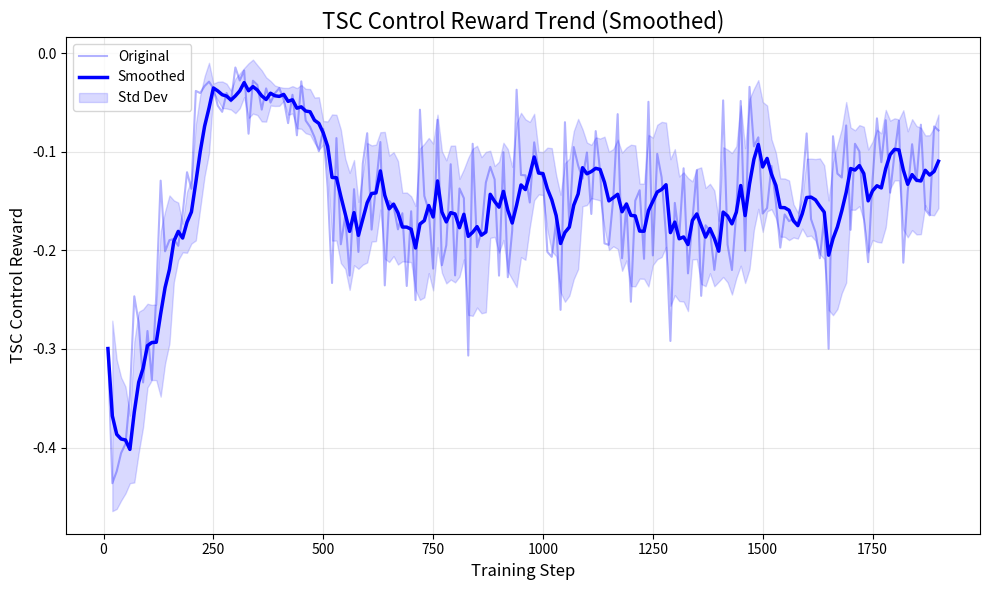

Plotting Format Reward (Chinese)...


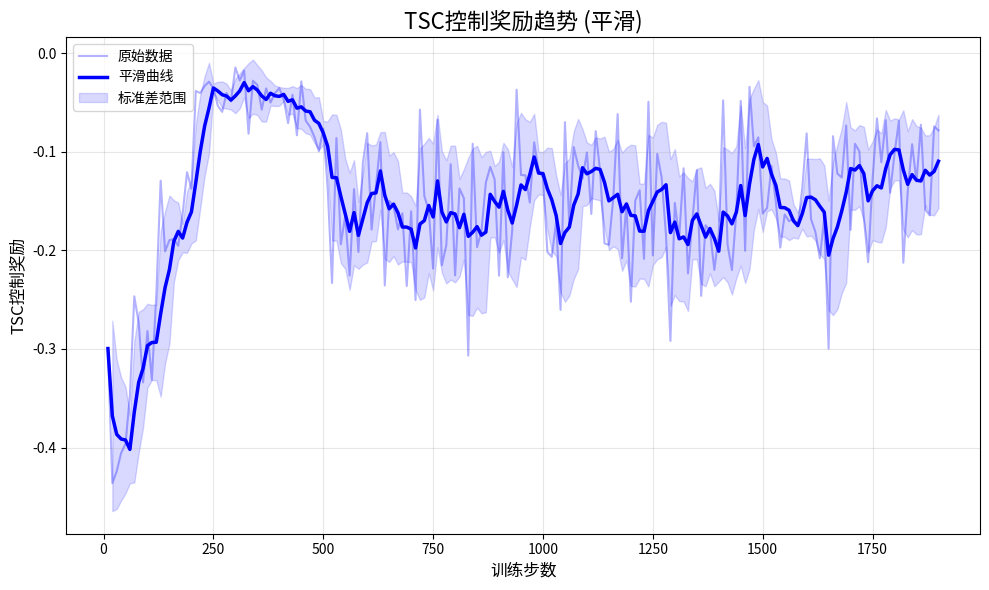

In [4]:
# Plot Format Reward Trend from training_statistics.md
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def parse_training_stats_manual(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Extract table rows using regex
    # Looking for <tr><td>...</td></tr>
    rows = re.findall(r'<tr>(.*?)</tr>', content, re.DOTALL)
    
    if not rows:
        return pd.DataFrame()
        
    # Parse headers
    header_match = re.search(r'<thead>(.*?)</thead>', content, re.DOTALL)
    headers = []
    if header_match:
        headers = re.findall(r'<th>(.*?)</th>', header_match.group(1))
    
    # Parse body rows
    parsed_rows = []
    for row in rows:
        cols = re.findall(r'<td>(.*?)</td>', row)
        if cols:
            # Convert to appropriate types
            converted_cols = []
            for c in cols:
                try:
                    converted_cols.append(float(c))
                except ValueError:
                    converted_cols.append(c)
            parsed_rows.append(converted_cols)
            
    if not headers and parsed_rows:
        # Fallback headers if detection failed
        headers = [f'col_{i}' for i in range(len(parsed_rows[0]))]
        
    df = pd.DataFrame(parsed_rows, columns=headers)
    return df

def plot_format_reward(file_path='/home/davidaray/SCU_TSC/training_statistics.md', lang='en'):
    try:
        # Use manual parsing
        df = parse_training_stats_manual(file_path)
        
        if df.empty:
            print(f"No data parsed from {file_path}")
            return
        
        target_col = 'rewards / tsc_reward_sim_fn / mean'
        if target_col not in df.columns:
            print(f"Column '{target_col}' not found. Available: {df.columns.tolist()}")
            return
            
        plt.figure(figsize=(10, 6))
        
        # Calculate smoothing
        window_size = 5
        df['smoothed'] = df[target_col].rolling(window=window_size, min_periods=1).mean()
        df['std'] = df[target_col].rolling(window=window_size, min_periods=1).std()
        
        # Original data (light)
        label_orig = 'Original' if lang == 'en' else '原始数据'
        sns.lineplot(data=df, x='Step', y=target_col, alpha=0.3, color='blue', label=label_orig)
        
        # Smoothed line
        label_smooth = 'Smoothed' if lang == 'en' else '平滑曲线'
        sns.lineplot(data=df, x='Step', y='smoothed', linewidth=2.5, color='blue', label=label_smooth)
        
        # Confidence interval
        label_std = 'Std Dev' if lang == 'en' else '标准差范围'
        plt.fill_between(df['Step'], 
                         df['smoothed'] - df['std'], 
                         df['smoothed'] + df['std'], 
                         color='blue', alpha=0.15, label=label_std)
        
        title = 'TSC Control Reward Trend (Smoothed)' if lang == 'en' else 'TSC控制奖励趋势 (平滑)'
        plt.title(title, fontsize=16)
        plt.xlabel('Training Step' if lang == 'en' else '训练步数', fontsize=12)
        plt.ylabel('TSC Control Reward' if lang == 'en' else 'TSC控制奖励', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting format reward: {e}")

print("Plotting Format Reward (English)...")
plot_format_reward(lang='en')

print("Plotting Format Reward (Chinese)...")
plot_format_reward(lang='cn')
